# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    ZeroPadding2D,
    LeakyReLU,
    ReLU,
    BatchNormalization,
    Flatten,
    AveragePooling2D,
    add,
    UpSampling2D,
    Dense,
    Flatten,
    Layer,
    Reshape,
    Dropout,
    Activation,
    Cropping2D,
)
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from pathlib import Path
from os import listdir
from PIL import Image
from pprint import pprint
from collections import defaultdict
from numpy.random import permutation
from abc import ABC
from typing import Tuple

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
%matplotlib inline

# Classes & Functions

## VAE

In [2]:
def format_history(history):
    return {k: v.numpy() for k, v in history.items()}
    

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.history = defaultdict(list)
    
    def update_history(self, train_history, test_history):
        for metric, value in train_history.items():
            self.history[metric].append(value)
        for metric, value in test_history.items():
            self.history[f'val_{metric}'].append(value)
    
    def fit(self, X_train, X_test=None, y_train=None, y_test=None, datagen=None, n_steps=None, batch_size=32, num_epochs=5, verbose=2):
        datagen = datagen or ImageDataGenerator()
        train_generator = datagen.flow(X_train, y_train if y_train is not None else X_train, batch_size=batch_size)
        
        n_steps = n_steps or int(math.ceil(len(X_train) / batch_size))
        for epoch in range(num_epochs):
            for step in range(n_steps):
                X_batch, y_batch = next(train_generator)
                train_history = format_history(self.train_step(X_batch, y_batch))
                if verbose >= 2:
                    if step % int(math.ceil(n_steps / 5)) == 0:
                        print('.', end='')

            test_history = (format_history(self.test_step(X_test, y_test))
                            if X_test is not None
                            else {})
            self.update_history(train_history, test_history)
            
            if verbose >= 1 and epoch % 1 == 0:
                print(f'Epoch {epoch}:', test_history)
        return self.history

    def get_losses(self, X, y=None):
        z_mean, z_log_var, z = self.encoder(X)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(X if y is None else y, reconstruction))
        reconstruction_loss *= 28 * 28
        # TODO: https://stats.stackexchange.com/questions/341954/balancing-reconstruction-vs-kl-loss-variational-autoencoder
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        return {'loss': total_loss,
                'reconstruction_loss': reconstruction_loss,
                'kl_loss': kl_loss}

    @tf.function
    def train_step(self, X, y=None):
        with tf.GradientTape() as tape:
            losses_dict = self.get_losses(X, y)
        grads = tape.gradient(losses_dict['loss'], self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return losses_dict

    @tf.function
    def test_step(self, X, y=None):
        losses_dict = self.get_losses(X, y)
        return losses_dict

In [3]:
def get_encoder(input_shape, latent_dim):
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(filters=16, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(encoder_inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=(1, 1), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=(7, 7), padding='same')(x)
    x = Reshape((128,))(x)
    x = BatchNormalization()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z])
    encoder._input_shape = input_shape
    encoder._latent_dim = latent_dim
    return encoder

def get_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim, ))
    x = Dense(128)(latent_inputs)
    x = Reshape((1,1,128,))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=(7, 7), padding='same')(x)
    x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', strides=(1, 1), padding='same')(x)
    
    decoder = Model(latent_inputs, decoded)
    decoder._latent_dim = latent_dim
    return decoder

def get_classifier(encoder, n_classes):
    encoder_inputs = Input(shape=encoder._input_shape)
    _, _, encoded = encoder(encoder_inputs)
    x = Dense(32, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
    classifier = Model(encoder_inputs, output)
    classifier._input_shape = encoder._input_shape
    classifier._latent_dim = encoder._latent_dim
    classifier._n_classes = n_classes
    return classifier

## Dataset

In [4]:
class Dataset(ABC):
    n_classes: int = None

    @staticmethod
    def get_X_y() -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError()

    def load_data(
        self,
        frac: float = 1.0,
        shuffle: bool = True,
        random_state: int = 42
    ) -> Tuple[np.ndarray, np.ndarray]:
        X, y = self.__class__.get_X_y()
        if shuffle:
            np.random.seed(random_state)
            shuffled = permutation(list(zip(X, y)))
            X, y = tuple(zip(*shuffled))
        if frac < 1.0:
            n = int(frac*len(X))
            X, y = X[:n], y[:n]
        return np.array(X), np.array(y)
        

class MNIST(Dataset):
    n_classes = 10
    input_shape = (28, 28, 1)

    @staticmethod
    def get_X_y():
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
        X = np.concatenate((X_train, X_test)).astype('float32') / 255
        X = np.reshape(X, (len(X), 28, 28, 1))
        y = np.concatenate((y_train, y_test))
        return X, y

## Visualization

In [5]:
def view_images(ims, decoder, encoder):
    input_shape = ims[0].shape
    decoded_ims = decoder(encoder(ims))

    plt.figure(figsize=(20, 4))
    n = len(ims)
    for i in range(n):
        # display original
        im = ims[i].reshape(*input_shape[:-1]) if input_shape[-1] == 1 else ims[i]
        ax = plt.subplot(2, n, i+1)
        plt.imshow(im)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        decoded_im = decoded_ims[i].numpy()
        decoded_im = decoded_ims[i].numpy().reshape(*input_shape[:-1]) if input_shape[-1] == 1 else decoded_ims[i].numpy()
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_im)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot(labels, plots, title='', xlabel=None, ylabel=None, legend_loc='best'):
    for p in plots:
        plt.plot(p)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(labels, loc=legend_loc)
    plt.show()

# Run

## Load Data

In [6]:
mnist = MNIST()

X, y = mnist.load_data(frac=0.5)
input_shape = X[0].shape

y_ohe = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, train_size=0.8, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)

(28000, 28, 28, 1)
(28000, 10)


## Instantiate Model

In [7]:
latent_dim = 16

In [8]:
encoder = get_encoder(input_shape, latent_dim)
#plot_model(encoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [9]:
decoder = get_decoder(latent_dim)
#plot_model(decoder, show_shapes=True, show_layer_names=False, expand_nested=True)

In [14]:
classifier = get_classifier(encoder, mnist.n_classes)
#plot_model(classifier, show_shapes=True, show_layer_names=False, expand_nested=True)

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

## Train VAE

In [11]:
training_config = dict(
    batch_size=32,
    num_epochs=20,
    verbose=2,
)
history = vae.fit(X_train, X_test, **training_config)

.....Epoch 0: {'loss': 28.124598, 'reconstruction_loss': 26.352037, 'kl_loss': 1.7725594}
.....Epoch 1: {'loss': 20.69678, 'reconstruction_loss': 18.691135, 'kl_loss': 2.0056436}
.....Epoch 2: {'loss': 18.464727, 'reconstruction_loss': 16.3694, 'kl_loss': 2.095327}
.....Epoch 3: {'loss': 17.360544, 'reconstruction_loss': 15.21753, 'kl_loss': 2.1430135}
.....Epoch 4: {'loss': 16.648293, 'reconstruction_loss': 14.483789, 'kl_loss': 2.1645038}
.....Epoch 5: {'loss': 16.313057, 'reconstruction_loss': 14.192493, 'kl_loss': 2.1205633}
.....Epoch 6: {'loss': 15.599704, 'reconstruction_loss': 13.380298, 'kl_loss': 2.2194064}
.....Epoch 7: {'loss': 15.352402, 'reconstruction_loss': 13.143362, 'kl_loss': 2.2090394}
.....Epoch 8: {'loss': 15.234913, 'reconstruction_loss': 13.041852, 'kl_loss': 2.1930606}
.....Epoch 9: {'loss': 15.121122, 'reconstruction_loss': 12.957361, 'kl_loss': 2.1637607}
.....Epoch 10: {'loss': 14.908346, 'reconstruction_loss': 12.725459, 'kl_loss': 2.1828876}
.....Epoch 11:

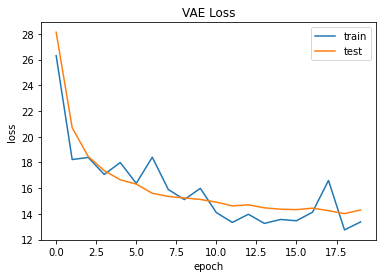

In [12]:
plot(labels=['train', 'test'],
     plots=(history['loss'], history['val_loss']),
     title='VAE Loss',
     xlabel='epoch',
     ylabel='loss')

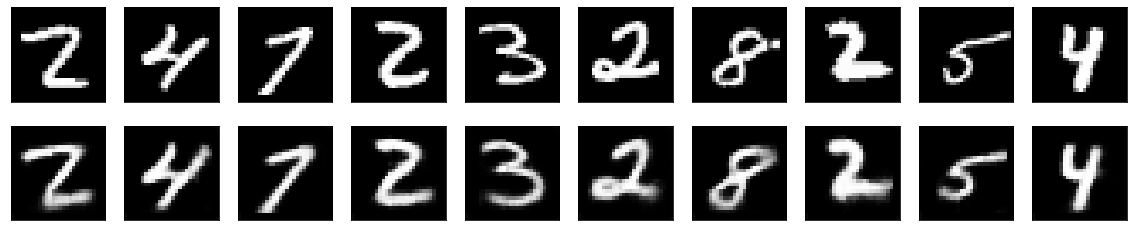

In [13]:
view_images(X_test[:10], decoder, encoder)

## Train Classifier

In [15]:
classifier.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)
history = classifier.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
875/875 [==============================] - 3s 4ms/step - loss: 0.2896 - categorical_accuracy: 0.9123 - val_loss: 0.1394 - val_categorical_accuracy: 0.9601
Epoch 2/10
875/875 [==============================] - 3s 4ms/step - loss: 0.1177 - categorical_accuracy: 0.9638 - val_loss: 0.1204 - val_categorical_accuracy: 0.9650
Epoch 3/10
875/875 [==============================] - 3s 3ms/step - loss: 0.0895 - categorical_accuracy: 0.9712 - val_loss: 0.1117 - val_categorical_accuracy: 0.9663
Epoch 4/10
875/875 [==============================] - 3s 4ms/step - loss: 0.0770 - categorical_accuracy: 0.9751 - val_loss: 0.1093 - val_categorical_accuracy: 0.9697
Epoch 5/10
875/875 [==============================] - 3s 4ms/step - loss: 0.0633 - categorical_accuracy: 0.9791 - val_loss: 0.1158 - val_categorical_accuracy: 0.9677
Epoch 6/10
875/875 [==============================] - 3s 4ms/step - loss: 0.0565 - categorical_accuracy: 0.9822 - val_loss: 0.1113 - val_categorical_accuracy: 0.9671
Epoc

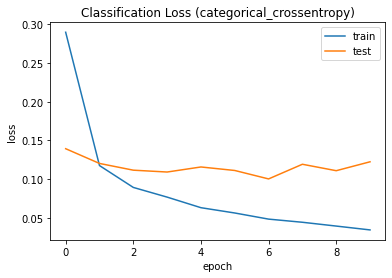

In [16]:
plot(labels=['train', 'test'],
     plots=(history.history['loss'], history.history['val_loss']),
     title='Classification Loss (categorical_crossentropy)',
     xlabel='epoch',
     ylabel='loss')

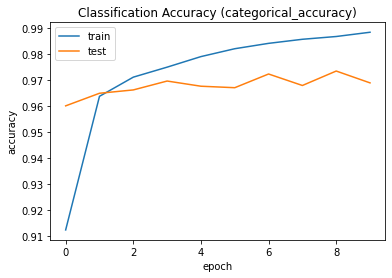

In [17]:
plot(labels=['train', 'test'],
     plots=(history.history['categorical_accuracy'],
            history.history['val_categorical_accuracy']),
     title='Classification Accuracy (categorical_accuracy)',
     xlabel='epoch',
     ylabel='accuracy')